In [1]:
import numpy as np

import keras
import keras.backend as K
import theano.tensor as T
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.fugure_format = 'retina'

Using TensorFlow backend.


In [2]:
IMAGE_PATCH_SHAPE = (64, 64, 1)

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Lambda, Flatten
from keras.activations import relu
    
descriptor = Sequential()
descriptor.add(Conv2D(96, kernel_size=7, strides=3, activation=relu, input_shape=IMAGE_PATCH_SHAPE))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Conv2D(192, kernel_size=5, strides=1, activation=relu))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.05))
descriptor.add(Conv2D(256, kernel_size=3, strides=1, activation=relu))
descriptor.add(Flatten())
descriptor.add(Lambda(lambda x : K.l2_normalize(x, axis=1))) # TODO check normalization

print(descriptor.input_shape, descriptor.output_shape)

(None, 64, 64, 1) (None, 256)


In [4]:
from keras.models import Model
from keras.layers import Input, Concatenate

input_a = Input(shape=IMAGE_PATCH_SHAPE)
input_b = Input(shape=IMAGE_PATCH_SHAPE)

descriptor_a = descriptor(input_a)
descriptor_b = descriptor(input_b)

decision = Concatenate()([descriptor_a, descriptor_b])
decision = Dense(512, activation=relu)(decision)
decision = Dense(1)(decision)
model = Model(inputs=[input_a, input_b], outputs=decision)

print(model.input_shape, model.output_shape)

[(None, 64, 64, 1), (None, 64, 64, 1)] (None, 1)


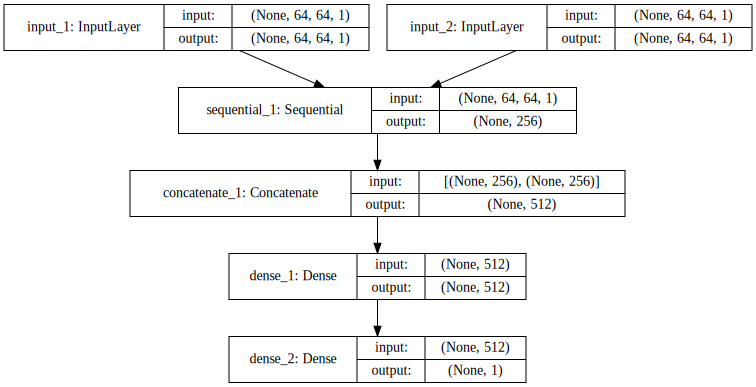

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy

def hinge_onehot(y_true, y_pred):
    y_true = y_true * 2 - 1
    y_pred = y_pred * 2 - 1

    return K.mean(K.maximum(1. - y_true * y_pred, 0.), axis=-1)

#model.compile(loss=hinge_onehot, optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True)) #TODO try Average SGD
model.compile(loss=hinge_onehot, optimizer=Adam())

In [8]:
from utils import patch_pairs_generator

NUM_PAIRS = 1000

output_generator = patch_pairs_generator('notredame', NUM_PAIRS, batch_size=128)

model.fit_generator(output_generator, steps_per_epoch=NUM_PAIRS // 128, epochs=5)

Epoch 1/5
7/7 [==============================] - 39s 6s/step - loss: 1.0297
Epoch 2/5
7/7 [==============================] - 11s 2s/step - loss: 1.0057
Epoch 3/5
7/7 [==============================] - 10s 1s/step - loss: 1.0097
Epoch 4/5
7/7 [==============================] - 10s 1s/step - loss: 1.0073
Epoch 5/5
7/7 [==============================] - 10s 1s/step - loss: 0.9984
